In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata, RBFInterpolator, RegularGridInterpolator
from scipy.stats import norm
from scipy.optimize import brentq
import warnings
warnings.filterwarnings('ignore')

In [2]:
complete_dataset = pd.read_csv('complete_dataset.csv')

In [3]:
complete_dataset

,Unnamed: 0,date,expiration,strike,call_put,bid,ask,vol,delta,gamma,...,vega,rho,days_to_expiry,mid_price,bid_ask_spread,spot_price,moneyness,time_to_expiry,risk_free_rate,dividend_yield
0,0,2025-07-21,2025-08-01,440.0,Call,188.55,190.28,0.6782,0.9988,0.0000,...,0.0035,0.1322,11,189.415,0.009133,628.770020,-0.356991,0.043651,0.04223,0.0116
1,1,2025-07-21,2025-08-01,470.0,Call,158.61,160.61,0.5727,0.9984,0.0000,...,0.0049,0.1412,11,159.610,0.012531,628.770020,-0.291033,0.043651,0.04223,0.0116
2,2,2025-07-21,2025-08-01,505.0,Call,123.69,125.46,0.4772,0.9964,0.0001,...,0.0111,0.1513,11,124.575,0.014208,628.770020,-0.219207,0.043651,0.04223,0.0116
3,3,2025-07-21,2025-08-01,520.0,Call,108.73,110.58,0.4272,0.9954,0.0002,...,0.0139,0.1557,11,109.655,0.016871,628.770020,-0.189937,0.043651,0.04223,0.0116
4,4,2025-07-21,2025-08-01,535.0,Call,93.78,95.66,0.3812,0.9936,0.0004,...,0.0191,0.1598,11,94.720,0.019848,628.770020,-0.161499,0.043651,0.04223,0.0116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88201,88201,2019-05-10,2019-06-28,300.0,Call,0.79,0.82,0.1021,0.1471,0.0213,...,0.2428,0.0559,49,0.805,0.037267,259.478903,0.145107,0.194444,0.02370,0.0116
88202,88202,2019-05-10,2019-06-28,300.0,Put,12.75,12.96,0.1159,-0.8193,0.0215,...,0.2871,-0.2287,49,12.855,0.016336,259.478903,0.145107,0.194444,0.02370,0.0116
88203,88203,2019-05-10,2019-06-28,308.0,Put,20.11,20.50,0.1359,-0.9036,0.0120,...,0.1914,-0.2115,49,20.305,0.019207,259.478903,0.171424,0.194444,0.02370,0.0116
88204,88204,2019-05-10,2019-06-28,315.0,Put,27.02,27.42,0.1640,-0.9257,0.0082,...,0.1538,-0.2032,49,27.220,0.014695,259.478903,0.193897,0.194444,0.02370,0.0116


In [9]:
# bs formula
def bs_call_price(S, K, T, r, q, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put_price(S, K, T, r, q, sigma):
    if T <= 0:
        return max(K - S, 0)
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)

def implied_volatility(S, K, T, r, q, market_price, option_type='call'):
    try:
        if option_type.lower() == 'call':
            objective = lambda sigma: bs_call_price(S, K, T, r, q, sigma) - market_price
        else:
            objective = lambda sigma: bs_put_price(S, K, T, r, q, sigma) - market_price
        
        iv = brentq(objective, 1e-6, 5.0, xtol=1e-8)
        return iv
    except:
        return np.nan

def calculate_bs_implied_volatility(complete_dataset):
    
    bs_ivs = []
    for idx, row in complete_dataset.iterrows():
        iv = implied_volatility(
            S=row['spot_price'],
            K=row['strike'], 
            T=row['time_to_expiry'],
            r=row['risk_free_rate'],
            q=row['dividend_yield'],
            market_price=row['mid_price'],
            option_type=row['call_put']
        )
        bs_ivs.append(iv)
    
    # create clean dataset
    clean_data = complete_dataset.copy()
    clean_data['bs_iv'] = bs_ivs
    
    # filter valid IVs only
    clean_data = clean_data[
        (clean_data['bs_iv'].notna()) & 
        (clean_data['bs_iv'] > 0.01) & 
        (clean_data['bs_iv'] < 5.0)  
    ].copy()
    return clean_data

def create_iv_time_series(clean_data):
    clean_data['date'] = pd.to_datetime(clean_data['date'])
    
    # create buckets for grouping
    clean_data['moneyness_bucket'] = pd.cut(clean_data['moneyness'], 
                                          bins=[-0.5, -0.15, -0.05, 0.05, 0.15, 0.5],
                                          labels=['Deep OTM Put', 'OTM Put', 'ATM', 'OTM Call', 'Deep OTM Call'])
    
    clean_data['dte_bucket'] = pd.cut(clean_data['time_to_expiry'],
                                    bins=[0, 0.08, 0.25, 0.5, 1.0, 3.0],
                                    labels=['0-30d', '30-90d', '90-180d', '180d-1y', '1y+'])
    
    # 1. ATM IV time series
    atm_iv_series = clean_data[
        abs(clean_data['moneyness']) < 0.05
    ].groupby('date')['bs_iv'].agg(['mean', 'std', 'count']).round(4)
    
    # 2. IV by moneyness (volatility smile evolution)
    iv_by_moneyness = clean_data.groupby(['date', 'moneyness_bucket'])['bs_iv'].mean().unstack()
    
    # 3. IV by time to expiry (term structure evolution)  
    iv_by_dte = clean_data.groupby(['date', 'dte_bucket'])['bs_iv'].mean().unstack()
    
    # 4. Daily IV statistics (for arbitrage bounds checking)
    daily_iv_stats = clean_data.groupby('date')['bs_iv'].agg([
        'min', 'max', 'mean', 'std', 'count'
    ]).round(4)
    return {
        'atm_iv_series': atm_iv_series,          
        'iv_by_moneyness': iv_by_moneyness,       # Smile evolution  
        'iv_by_dte': iv_by_dte,                   # Term structure
        'daily_stats': daily_iv_stats,            # Daily bounds
        'raw_data': clean_data                    # Full dataset
    }

def build_vol_surface_for_date(clean_data, target_date=None):
   
    clean_data['date'] = pd.to_datetime(clean_data['date'])
    
    if target_date is None:
        target_date = clean_data['date'].max()
    else:
        target_date = pd.to_datetime(target_date)

    day_data = clean_data[clean_data['date'] == target_date].copy()
    
    if len(day_data) < 10:
        return None
    
    # prepare coordinates
    X = day_data['time_to_expiry'].values
    Y = day_data['moneyness'].values  
    Z = day_data['bs_iv'].values
    valid_mask = ~(np.isnan(X) | np.isnan(Y) | np.isnan(Z))
    X, Y, Z = X[valid_mask], Y[valid_mask], Z[valid_mask]
    
    # remove duplicates by averaging
    unique_points = {}
    for i in range(len(X)):
        key = (round(X[i], 6), round(Y[i], 6))
        if key not in unique_points:
            unique_points[key] = [Z[i]]
        else:
            unique_points[key].append(Z[i])
    
    # Average duplicate points
    X_clean = np.array([pt[0] for pt in unique_points.keys()])
    Y_clean = np.array([pt[1] for pt in unique_points.keys()]) 
    Z_clean = np.array([np.mean(vals) for vals in unique_points.values()])
    
    # regular grid for interpolation
    time_min, time_max = X_clean.min(), X_clean.max()
    money_min, money_max = Y_clean.min(), Y_clean.max()
    time_grid = np.linspace(time_min, time_max, 30)
    moneyness_grid = np.linspace(money_min, money_max, 40)
    TIME_MESH, MONEY_MESH = np.meshgrid(time_grid, moneyness_grid)
    
    # RBF interpolating
    try:
        rbf = RBFInterpolator(
            np.column_stack([X_clean, Y_clean]), Z_clean,
            kernel='thin_plate_spline',
            smoothing=0.05
        )
        IV_MESH = rbf(np.column_stack([TIME_MESH.ravel(), MONEY_MESH.ravel()])).reshape(TIME_MESH.shape)
        method_used = 'RBF'
    except Exception as e:
        IV_MESH = griddata((X_clean, Y_clean), Z_clean, (TIME_MESH, MONEY_MESH), method='linear')
        method_used = 'Linear'
    
    return {
        'date': target_date,
        'time_grid': time_grid,               # 1D array of time points
        'moneyness_grid': moneyness_grid,     # 1D array of moneyness points  
        'TIME_MESH': TIME_MESH,               # 2D meshgrid of times
        'MONEY_MESH': MONEY_MESH,             # 2D meshgrid of moneyness
        'IV_MESH': IV_MESH,                   # 2D IV values
        'raw_points': (X_clean, Y_clean, Z_clean),  # Original points
        'method': method_used,
        'shape': IV_MESH.shape
    }

def plot_vol_surface(surface_data):

    fig = plt.figure(figsize=(15, 10))
    
    # Main 3D surface
    ax1 = fig.add_subplot(221, projection='3d')
    
    surf = ax1.plot_surface(
        surface_data['TIME_MESH'],
        surface_data['MONEY_MESH'],
        surface_data['IV_MESH'],
        cmap='viridis', alpha=0.8
    )
    
    # Add raw data points
    X_raw, Y_raw, Z_raw = surface_data['raw_points']
    ax1.scatter(X_raw, Y_raw, Z_raw, c='red', s=20, alpha=0.8)
    
    ax1.set_xlabel('Time to Expiry')
    ax1.set_ylabel('Moneyness')
    ax1.set_zlabel('Black-Scholes IV')
    ax1.set_title(f'Volatility Surface - {surface_data["date"].date()}')
    
    # ATM term structure
    ax2 = fig.add_subplot(222)
    atm_idx = np.abs(surface_data['moneyness_grid']).argmin()  
    atm_iv = surface_data['IV_MESH'][atm_idx, :]
    valid_atm = ~np.isnan(atm_iv)
    
    ax2.plot(surface_data['time_grid'][valid_atm], atm_iv[valid_atm], 'b-', linewidth=2, marker='o')
    ax2.set_xlabel('Time to Expiry')
    ax2.set_ylabel('ATM IV')
    ax2.set_title('ATM Volatility Term Structure')
    ax2.grid(True, alpha=0.3)
    
    # vol smile for different maturities
    ax3 = fig.add_subplot(223)
    time_indices = [5, 10, 15, 20, 25]  
    colors = ['red', 'orange', 'green', 'blue', 'purple']
    
    for idx, color in zip(time_indices, colors):
        if idx < surface_data['IV_MESH'].shape[1]:
            smile = surface_data['IV_MESH'][:, idx]
            valid_smile = ~np.isnan(smile)
            if np.any(valid_smile):
                ax3.plot(surface_data['moneyness_grid'][valid_smile], smile[valid_smile], 
                        color=color, linewidth=2, marker='o', markersize=3,
                        label=f'T={surface_data["time_grid"][idx]:.2f}y')
    
    ax3.set_xlabel('Moneyness')
    ax3.set_ylabel('Implied Volatility') 
    ax3.set_title('Volatility Smiles')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(224)
    ax4.axis('off')
    
    valid_iv = surface_data['IV_MESH'][~np.isnan(surface_data['IV_MESH'])]
    stats_text = f"""
    Surface Statistics:
    
    Grid Size: {surface_data['shape'][0]} × {surface_data['shape'][1]}
    Method: {surface_data['method']}
    Raw Points: {len(surface_data['raw_points'][0])}
    
    IV Range: {valid_iv.min():.3f} - {valid_iv.max():.3f}
    Mean IV: {valid_iv.mean():.3f}
    Std IV: {valid_iv.std():.3f}
    
    Time Range: {surface_data['time_grid'].min():.3f} - {surface_data['time_grid'].max():.3f}
    Moneyness Range: {surface_data['moneyness_grid'].min():.3f} - {surface_data['moneyness_grid'].max():.3f}
    """
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

def analyze_volatility_complete(complete_dataset, target_date=None):

    clean_data = calculate_bs_implied_volatility(complete_dataset)
    iv_time_series = create_iv_time_series(clean_data)
    surface_data = build_vol_surface_for_date(clean_data, target_date)
    if surface_data is not None:
        plot_vol_surface(surface_data)
    
    # plot
    return {
        'clean_data': clean_data,              
        'iv_time_series': iv_time_series,     
        'surface_data': surface_data,          
        'summary': {
            'total_options': len(clean_data),
            'date_range': (clean_data['date'].min(), clean_data['date'].max()),
            'iv_range': (clean_data['bs_iv'].min(), clean_data['bs_iv'].max())
        }
    }

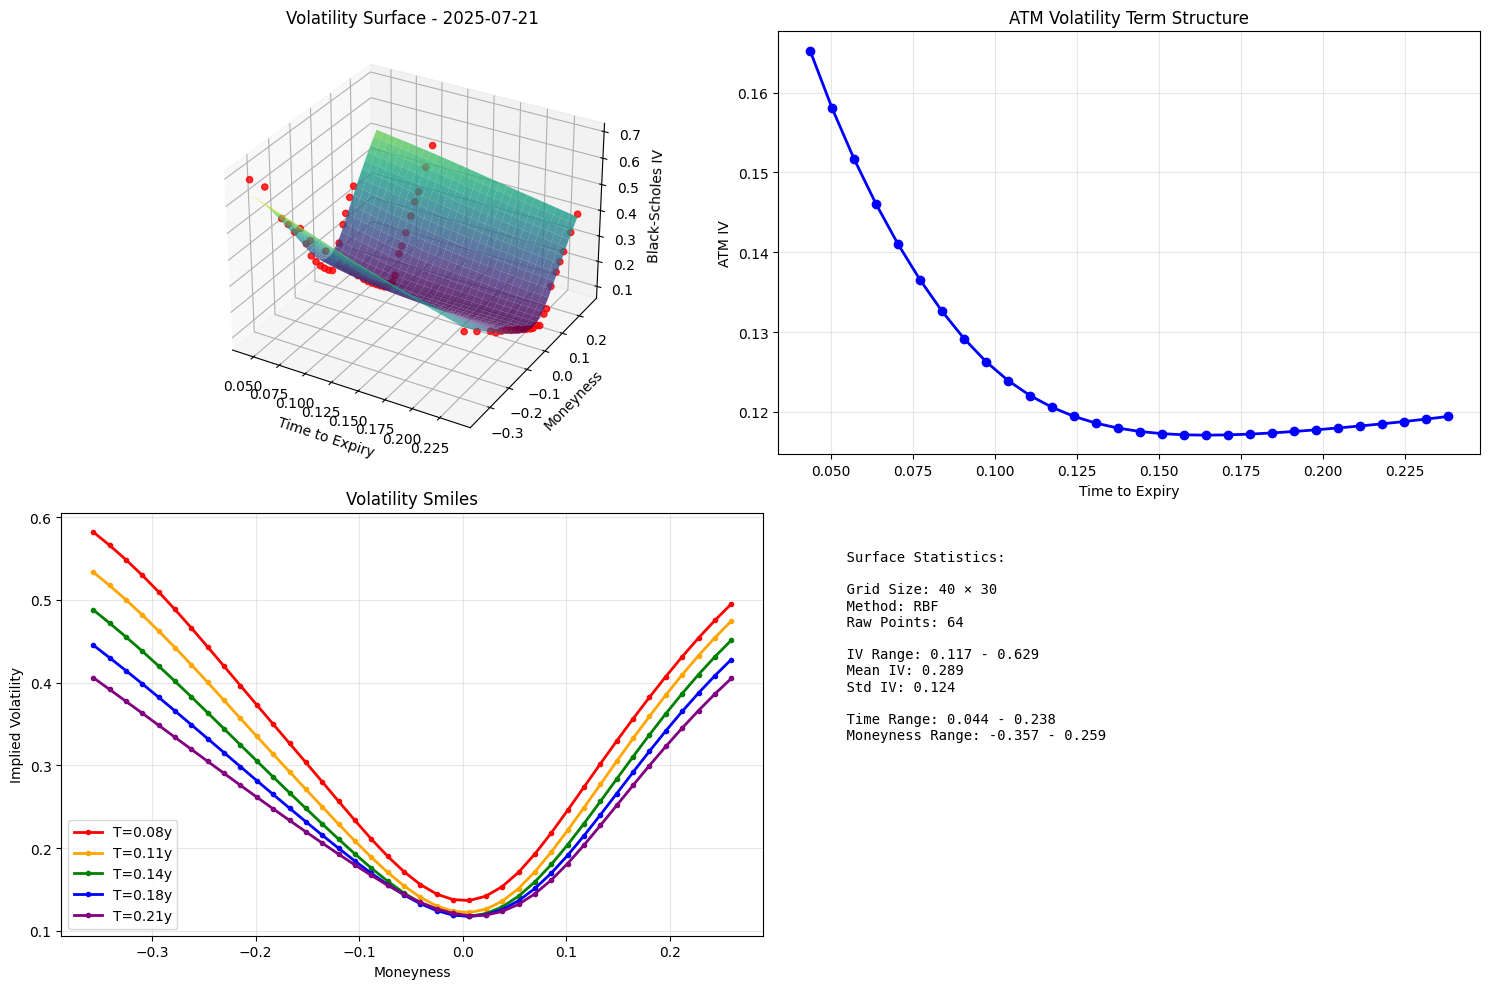

In [10]:
results = analyze_volatility_complete(complete_dataset)

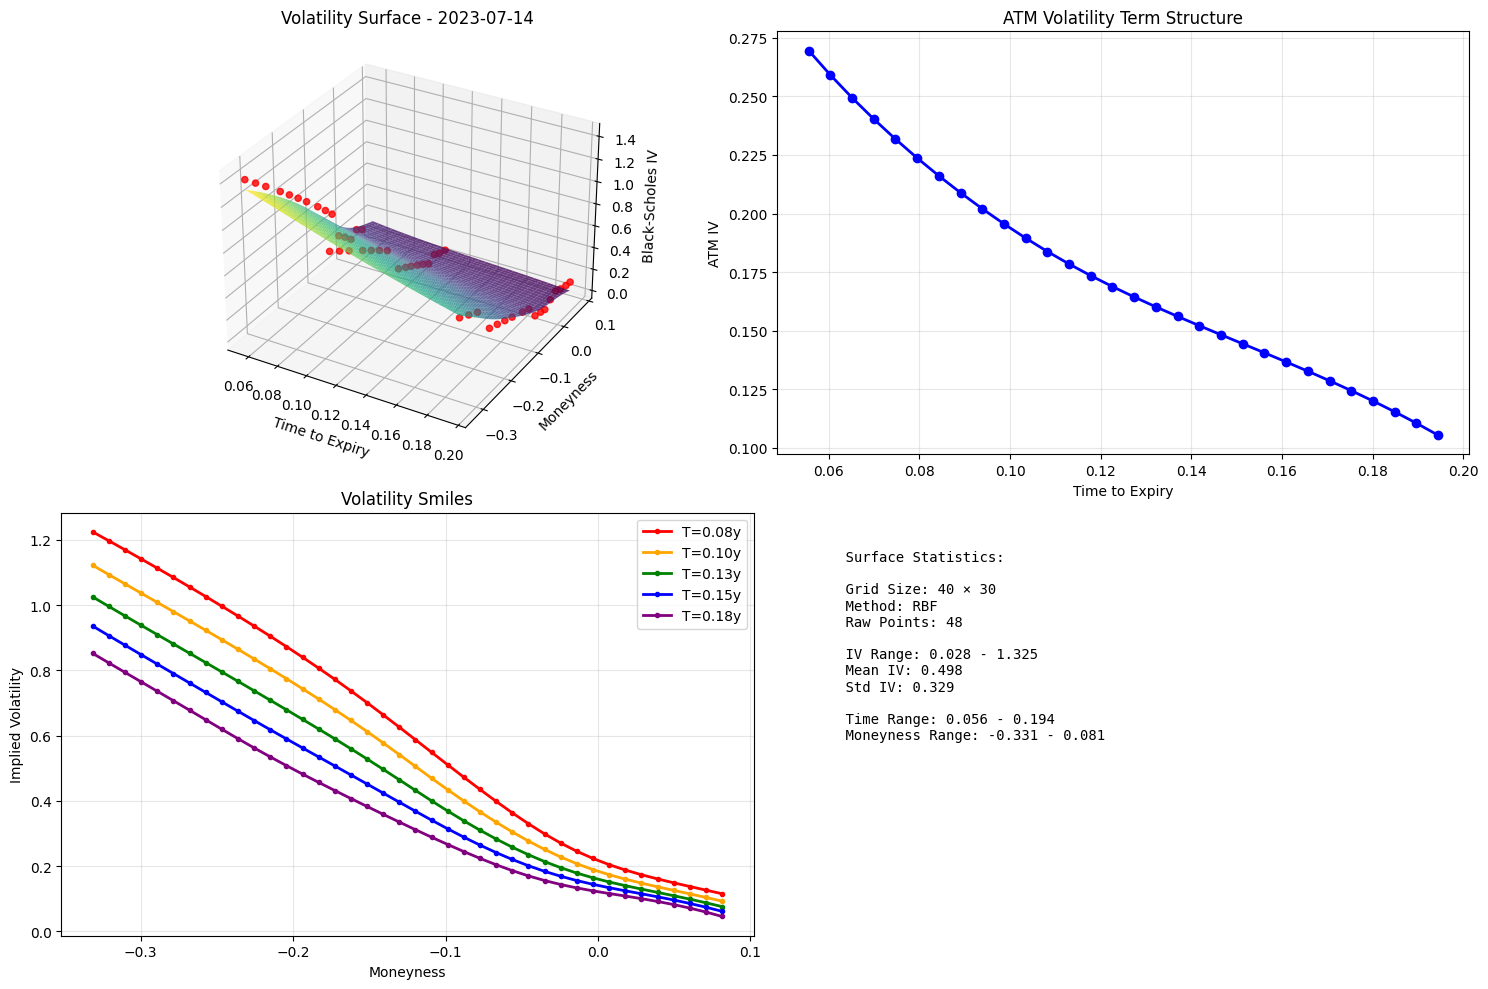

In [11]:
results = analyze_volatility_complete(complete_dataset, target_date='2023-07-14')

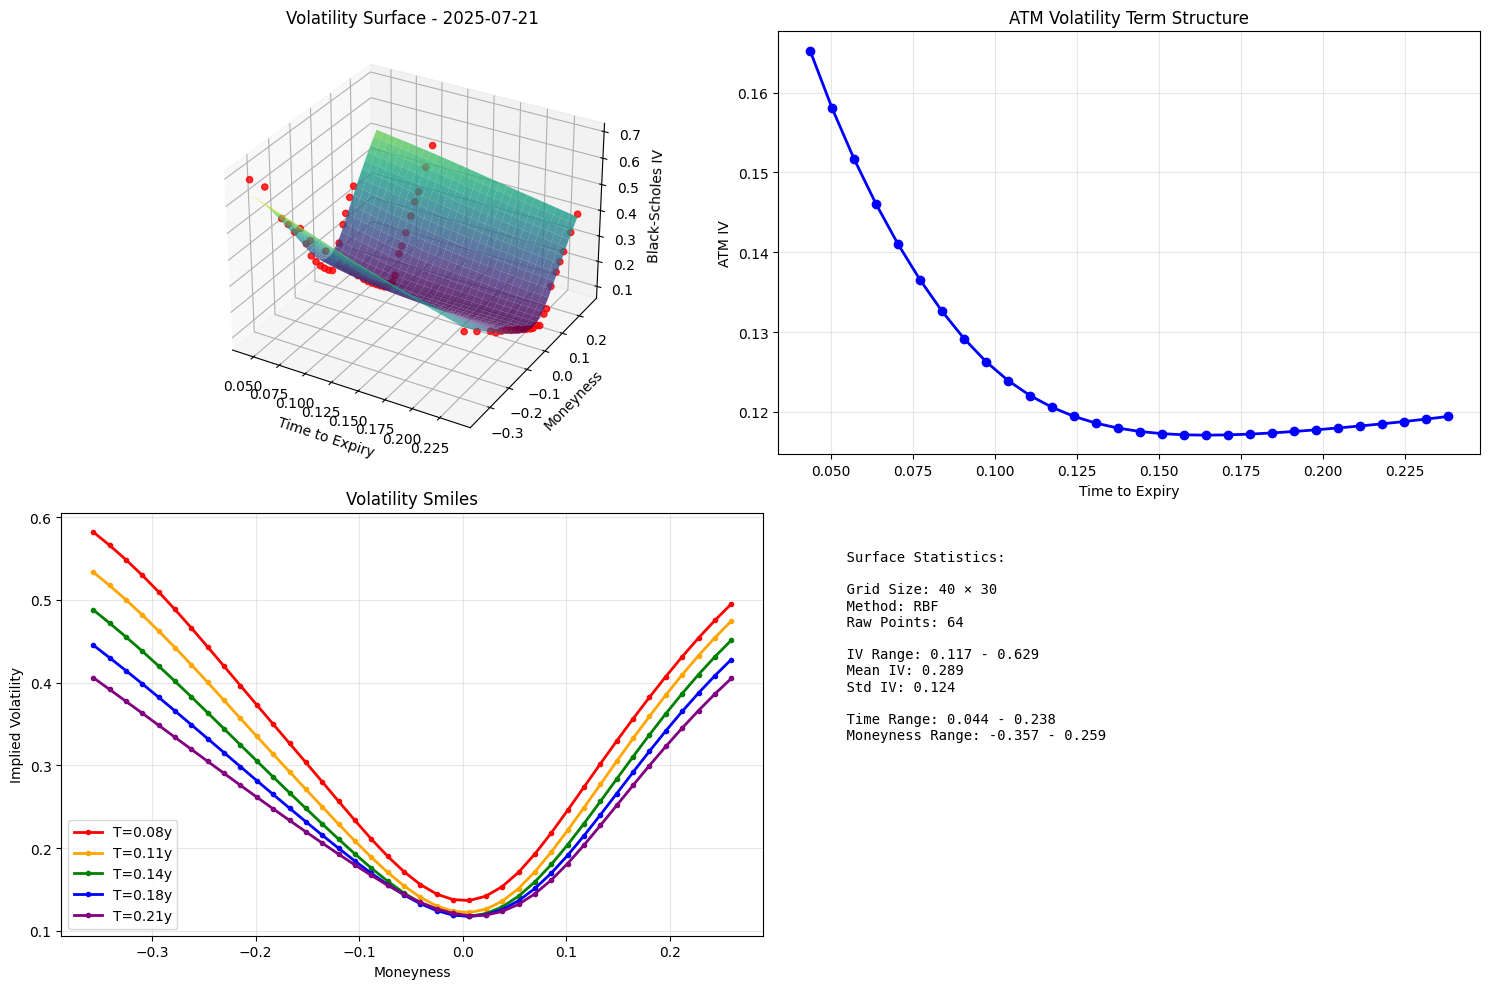

In [12]:
results = analyze_volatility_complete(complete_dataset)
atm_series = results['iv_time_series']['atm_iv_series']
iv_surface = results['surface_data']['IV_MESH']
clean_data = results['clean_data']

In [8]:
clean_data

,Unnamed: 0,date,expiration,strike,call_put,bid,ask,vol,delta,gamma,...,mid_price,bid_ask_spread,spot_price,moneyness,time_to_expiry,risk_free_rate,dividend_yield,bs_iv,moneyness_bucket,dte_bucket
0,0,2025-07-21,2025-08-01,440.0,Call,188.55,190.28,0.6782,0.9988,0.0000,...,189.415,0.009133,628.770020,-0.356991,0.043651,0.04223,0.0116,0.687249,Deep OTM Put,0-30d
1,1,2025-07-21,2025-08-01,470.0,Call,158.61,160.61,0.5727,0.9984,0.0000,...,159.610,0.012531,628.770020,-0.291033,0.043651,0.04223,0.0116,0.620386,Deep OTM Put,0-30d
2,2,2025-07-21,2025-08-01,505.0,Call,123.69,125.46,0.4772,0.9964,0.0001,...,124.575,0.014208,628.770020,-0.219207,0.043651,0.04223,0.0116,0.457686,Deep OTM Put,0-30d
3,3,2025-07-21,2025-08-01,520.0,Call,108.73,110.58,0.4272,0.9954,0.0002,...,109.655,0.016871,628.770020,-0.189937,0.043651,0.04223,0.0116,0.416873,Deep OTM Put,0-30d
4,4,2025-07-21,2025-08-01,535.0,Call,93.78,95.66,0.3812,0.9936,0.0004,...,94.720,0.019848,628.770020,-0.161499,0.043651,0.04223,0.0116,0.369734,Deep OTM Put,0-30d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88193,88193,2019-05-10,2019-06-28,277.0,Call,14.49,14.65,0.1864,0.7295,0.0167,...,14.570,0.010981,259.478903,0.065342,0.194444,0.02370,0.0116,0.468138,OTM Call,30-90d
88195,88195,2019-05-10,2019-06-28,282.0,Call,10.47,10.62,0.1679,0.6492,0.0208,...,10.545,0.014225,259.478903,0.083232,0.194444,0.02370,0.0116,0.412579,OTM Call,30-90d
88197,88197,2019-05-10,2019-06-28,288.0,Call,6.17,6.25,0.1446,0.5162,0.0260,...,6.210,0.012882,259.478903,0.104285,0.194444,0.02370,0.0116,0.344790,OTM Call,30-90d
88199,88199,2019-05-10,2019-06-28,294.0,Call,2.71,2.77,0.1200,0.3344,0.0287,...,2.740,0.021898,259.478903,0.124904,0.194444,0.02370,0.0116,0.275622,OTM Call,30-90d


In [9]:
clean_data.to_csv("clean_data.csv")